# WaMoS: Fitování 2f-WMS píků pomocí druhé derivace Pearson VII

Tento notebook rozšiřuje skript `wamos04.ipynb` o kvantitativní analýzu absorpčních linií:
- Detekce lokálních minim v normalizovaném 2f signálu
- Fitování každého piku pomocí druhé derivace Pearson VII
- Detekce zero-crossing bodů
- Integrace ploch pod křivkou
- Výpočet poměrů mezi sousedními píkami
- Vizualizace a tabulkový výstup


In [17]:
import glob
import pandas as pd
import os

# Path to experimental folder
exp_path = "./exp/2025-11-30_Qin10_lmin_phi1_ch4air_Tld51stC_HAB(from3to11mm)_00000"

# Mapping of prefixes to heights
height_map = {
    "M1": 3,
    "M2": 5,
    "M3": 7,
    "M4": 9,
    "C2": 11
}

# Detect all TXT files
files = glob.glob(f"{exp_path}/*.txt")

# Dictionaries for signals
signals_X2f = {}
signals_X4f = {}
time_ref = None

for f in files:
    fname = os.path.basename(f)
    prefix = fname.split("_")[0]
    
    if prefix in height_map:
        try:
            df = pd.read_csv(f, sep=";", skiprows=5, header=None)
            df = df.iloc[:, :2]
            df.columns = ["time_s", "X_signal_V"]
            
            if time_ref is None:
                time_ref = df["time_s"].values
            
            height = height_map[prefix]
            
            if "_2f_" in fname:
                signals_X2f[height] = df["X_signal_V"].values
            elif "_4f_" in fname:
                signals_X4f[height] = df["X_signal_V"].values
        except Exception as e:
            print(f"❌ Could not load {fname}: {e}")

# Build combined DataFrames with explicit column order
ordered_heights = [3, 5, 7, 9, 11]

df_X2f = pd.DataFrame({"time_s": time_ref})
for h in ordered_heights:
    if h in signals_X2f:
        df_X2f[f"{h}mm"] = signals_X2f[h]

df_X4f = pd.DataFrame({"time_s": time_ref})
for h in ordered_heights:
    if h in signals_X4f:
        df_X4f[f"{h}mm"] = signals_X4f[h]

# Print heads
print("X2f datasets:")
print(df_X2f.head())

print("\nX4f datasets:")
print(df_X4f.head())


X2f datasets:
   time_s       3mm       5mm       7mm       9mm      11mm
0  0.0000  0.309377  0.208075  0.208075  0.223985  0.213419
1  0.0005  0.250709  0.208075  0.213419  0.234674  0.197385
2  0.0010  0.005345  0.128027  0.373391  0.330757  0.165316
3  0.0015 -0.453314 -0.079923  0.735968  0.709368  0.090737
4  0.0020 -1.039880 -0.367922  1.322650  1.301270  0.042758

X4f datasets:
   time_s       3mm       5mm       7mm       9mm      11mm
0  0.0000 -1.933200 -2.207900 -1.981180 -2.191870 -1.866580
1  0.0005 -1.946500 -2.237240 -2.061230 -2.103870 -1.839860
2  0.0010 -1.695920 -2.298520 -2.047930 -1.623950 -1.450560
3  0.0015 -0.383956 -1.133220 -1.162560 -0.264009  0.005345
4  0.0020  0.381346  0.080048 -0.255929  0.423980  1.104010


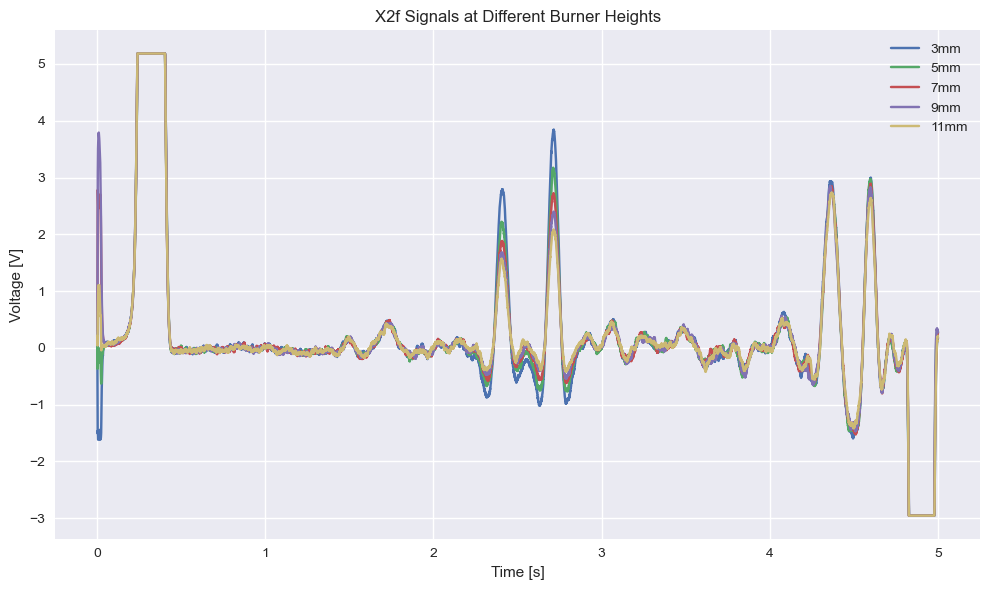

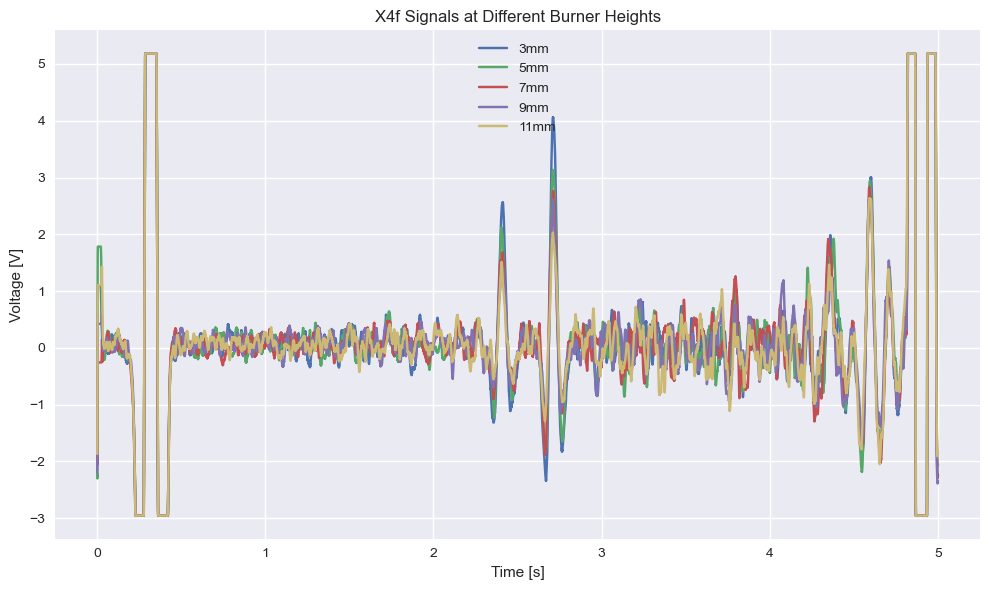

In [22]:
import matplotlib.pyplot as plt

# Plot X2f signals
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))

for col in df_X2f.columns[1:]:  # skip time_s
    plt.plot(df_X2f["time_s"], df_X2f[col], label=col)

plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("X2f Signals at Different Burner Heights")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot X4f signals
plt.figure(figsize=(10, 6))

for col in df_X4f.columns[1:]:  # skip time_s
    plt.plot(df_X4f["time_s"], df_X4f[col], label=col)

plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("X4f Signals at Different Burner Heights")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
import glob
import pandas as pd
import os

# Path to experimental folder
exp_path = "./exp/2025-11-30_Qin10_lmin_phi1_ch4air_Tld51stC_HAB(from3to11mm)_00000"

# Detect all TXT files
files = glob.glob(f"{exp_path}/*.txt")

# Collect C1 files
c1_dfs = []
for f in files:
    fname = os.path.basename(f)
    if fname.startswith("C1_"):
        try:
            df = pd.read_csv(f, sep=";", skiprows=5, header=None)
            df = df.iloc[:, :2]
            df.columns = ["time_s", "X_signal_V"]
            c1_dfs.append(df)
        except Exception as e:
            print(f"❌ Could not load {fname}: {e}")

# Build combined DataFrame if exactly two C1 files found
if len(c1_dfs) == 2:
    df_detector = pd.DataFrame({
        "time_s": c1_dfs[0]["time_s"].values,
        "detector1_V": c1_dfs[0]["X_signal_V"].values,
        "detector2_V": c1_dfs[1]["X_signal_V"].values
    })
    df_detector["detector_mean_V"] = (df_detector["detector1_V"] + df_detector["detector2_V"]) / 2.0
    
    print("Detector response DataFrame:")
    print(df_detector.head())
else:
    print(f"⚠️ Expected 2 C1 files, found {len(c1_dfs)}")

Detector response DataFrame:
   time_s  detector1_V  detector2_V  detector_mean_V
0  0.0000     0.348133     0.608388         0.478261
1  0.0005     0.106026     0.147069         0.126548
2  0.0010     0.066549     0.067071         0.066810
3  0.0015     0.067618     0.066549         0.067084
4  0.0020     0.068687     0.061204         0.064946


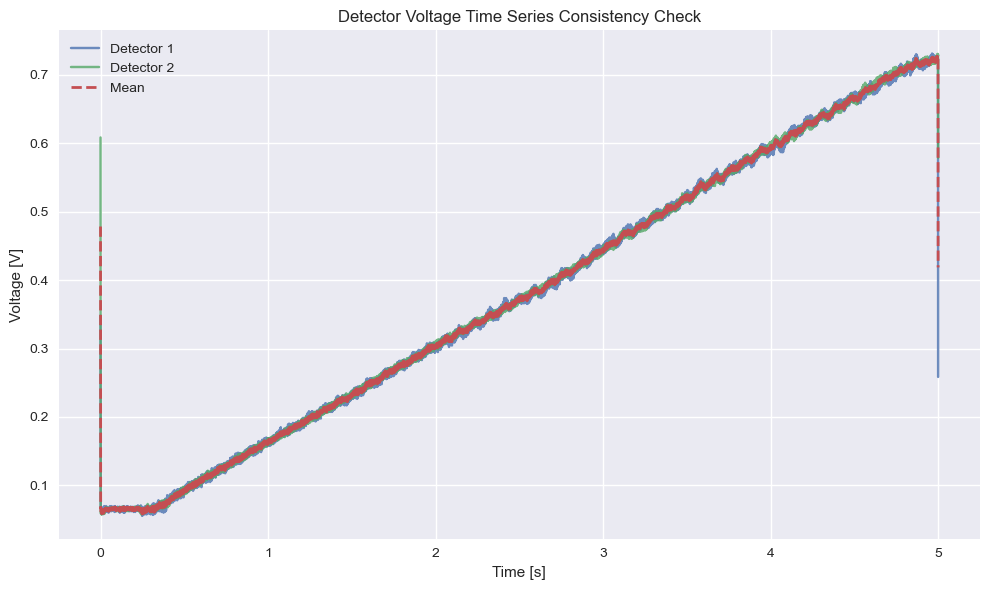

In [21]:
import matplotlib.pyplot as plt

# Assuming df_detector is already created from your C1 files:
# df_detector has columns: time_s, detector1_V, detector2_V, detector_mean_V

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))

# Plot the three time series
plt.plot(df_detector["time_s"], df_detector["detector1_V"], label="Detector 1", alpha=0.8)
plt.plot(df_detector["time_s"], df_detector["detector2_V"], label="Detector 2", alpha=0.8)
plt.plot(df_detector["time_s"], df_detector["detector_mean_V"], label="Mean", linewidth=2, linestyle='--')

# Labels and formatting
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("Detector Voltage Time Series Consistency Check")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [42]:
import numpy as np
import pandas as pd

# Safe divide function
def safe_divide(num, denom, eps=1e-9):
    return num / (denom + eps)

# Step 1: Quadratic fit of detector mean
coeffs = np.polyfit(df_detector["time_s"], df_detector["detector_mean_V"], deg=2)
poly = np.poly1d(coeffs)
df_detector["D_fit"] = poly(df_detector["time_s"])

# Step 2: Build normalized X2f/√X4f DataFrame using safe_divide
df_X2f4fnorm = pd.DataFrame({"time_s": df_X2f["time_s"]})
k = 10

for col in df_X2f.columns[1:]:  # skip time_s
    if col in df_X4f.columns:
        X2f = df_X2f[col].values
        X4f = df_X4f[col].values
        D_fit = df_detector["D_fit"].values

        # Apply safe divide twice: first for ratio, then normalization
        ratio = safe_divide(X2f, np.sqrt(X4f + k))
        ratio_normalized = safe_divide(ratio, D_fit)

        df_X2f4fnorm[col] = ratio_normalized

# Step 3: Inspect results
print("Detector DataFrame with D_fit:")
print(df_detector.head())

print("\nNormalized X2f/√X4f DataFrame (safe divide applied):")
print(df_X2f4fnorm.head())


Detector DataFrame with D_fit:
   time_s  detector1_V  detector2_V  detector_mean_V     D_fit
0  0.0000     0.348133     0.608388         0.478261  0.034289
1  0.0005     0.106026     0.147069         0.126548  0.034354
2  0.0010     0.066549     0.067071         0.066810  0.034418
3  0.0015     0.067618     0.066549         0.067084  0.034483
4  0.0020     0.068687     0.061204         0.064946  0.034548

Normalized X2f/√X4f DataFrame (safe divide applied):
   time_s       3mm       5mm        7mm        9mm      11mm
0  0.0000  3.176720  2.173873   2.142921   2.337690  2.182419
1  0.0005  2.571590  2.173882   2.204858   2.430983  2.011359
2  0.0010  0.053888  1.340364   3.847087   3.320456  1.642685
3  0.0015 -4.239306 -0.778369   7.179424   6.592883  0.831887
4  0.0020 -9.341947 -3.354328  12.264666  11.666260  0.371419


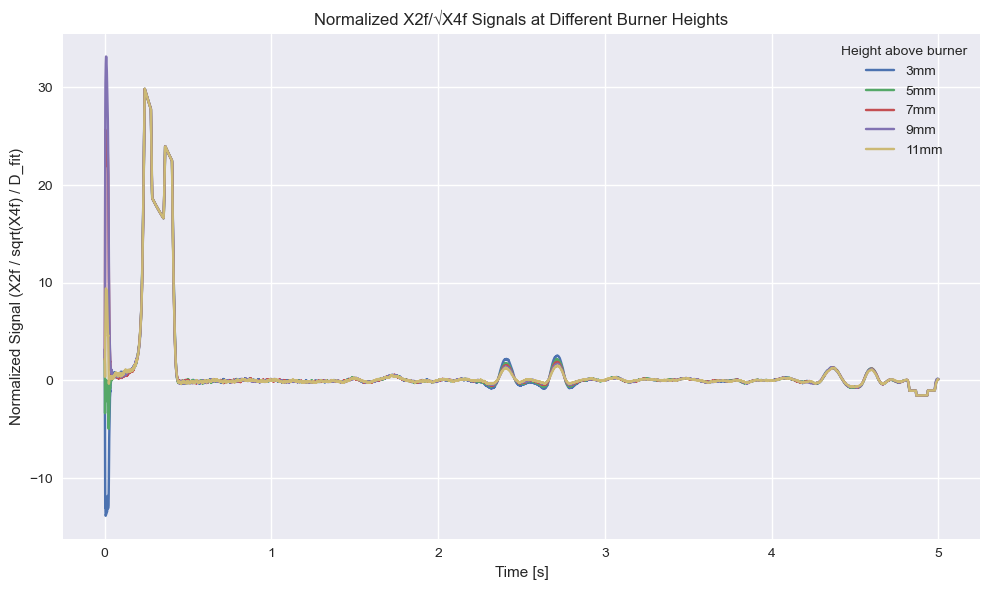

In [43]:
import matplotlib.pyplot as plt

# Assuming df_X2f4fnorm is already created with columns:
# time_s, 3mm, 5mm, 7mm, 9mm, 11mm

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))

# Plot normalized signals for each height
for col in df_X2f4fnorm.columns[1:]:  # skip time_s
    plt.plot(df_X2f4fnorm["time_s"], df_X2f4fnorm[col], label=col)

# Labels and formatting
plt.xlabel("Time [s]")
plt.ylabel("Normalized Signal (X2f / sqrt(X4f) / D_fit)")
plt.title("Normalized X2f/√X4f Signals at Different Burner Heights")
plt.legend(title="Height above burner")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [47]:
# Define filename according to experiment metadata
filename = "2025-11-30_Qin10_lmin_phi1_ch4air_X2f4fnorm.csv"

# Export DataFrame to CSV in your experimental folder
output_path = os.path.join(exp_path, filename)
df_X2f4fnorm.to_csv(output_path, index=False)

print(f"✅ Exported normalized DataFrame to {output_path}")


✅ Exported normalized DataFrame to ./exp/2025-11-30_Qin10_lmin_phi1_ch4air_Tld51stC_HAB(from3to11mm)_00000\2025-11-30_Qin10_lmin_phi1_ch4air_X2f4fnorm.csv


   time_s       3mm       5mm       7mm       9mm          11mm
0  2.0000 -0.016611 -0.033289 -0.011013 -0.055686 -5.539048e-03
1  2.0005  0.016730 -0.044419 -0.005568 -0.038891  2.213939e-02
2  2.0010  0.005572 -0.038887 -0.005567 -0.027736  3.314527e-02
3  2.0015  0.027841 -0.022161  0.005562 -0.022149 -9.462114e-09
4  2.0020  0.027801 -0.022159  0.011115 -0.022126  2.202916e-02


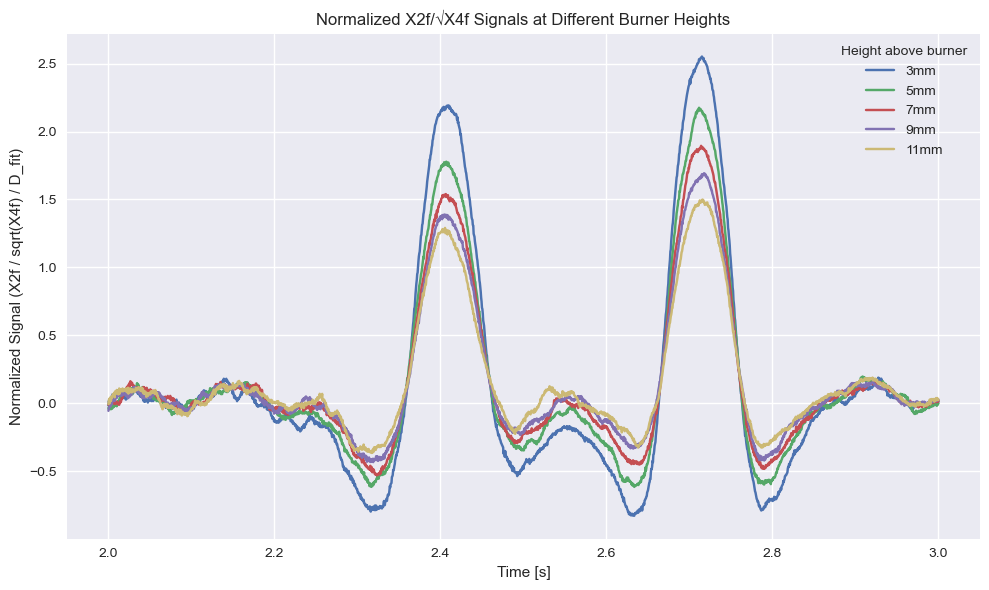

In [46]:
import numpy as np
import pandas as pd

def safe_divide(num, denom, eps=1e-8):
    """Safe division to avoid division by zero or unstable denominators."""
    return num / (denom + eps)

# Step 1: Quadratic fit of detector mean
coeffs = np.polyfit(df_detector["time_s"], df_detector["detector_mean_V"], deg=2)
poly = np.poly1d(coeffs)
df_detector["D_fit"] = poly(df_detector["time_s"])

# Step 2: Focus only on 2–3 s interval
mask = (df_X2f["time_s"] >= 2.0) & (df_X2f["time_s"] <= 3.0)

time_window = df_X2f["time_s"][mask].values
df_X2f4fnorm = pd.DataFrame({"time_s": time_window})

k = 10  # stabilizing constant for sqrt

for col in df_X2f.columns[1:]:  # skip time_s
    if col in df_X4f.columns:
        X2f = df_X2f[col][mask].values
        X4f = df_X4f[col][mask].values
        D_fit = df_detector["D_fit"][mask].values

        # Safe normalization
        ratio = safe_divide(X2f, np.sqrt(X4f + k), eps=1e-8)
        ratio_normalized = safe_divide(ratio, D_fit, eps=1e-8)

        df_X2f4fnorm[col] = ratio_normalized

print(df_X2f4fnorm.head())

import matplotlib.pyplot as plt

# Assuming df_X2f4fnorm is already created with columns:
# time_s, 3mm, 5mm, 7mm, 9mm, 11mm

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))

# Plot normalized signals for each height
for col in df_X2f4fnorm.columns[1:]:  # skip time_s
    plt.plot(df_X2f4fnorm["time_s"], df_X2f4fnorm[col], label=col)

# Labels and formatting
plt.xlabel("Time [s]")
plt.ylabel("Normalized Signal (X2f / sqrt(X4f) / D_fit)")
plt.title("Normalized X2f/√X4f Signals at Different Burner Heights")
plt.legend(title="Height above burner")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

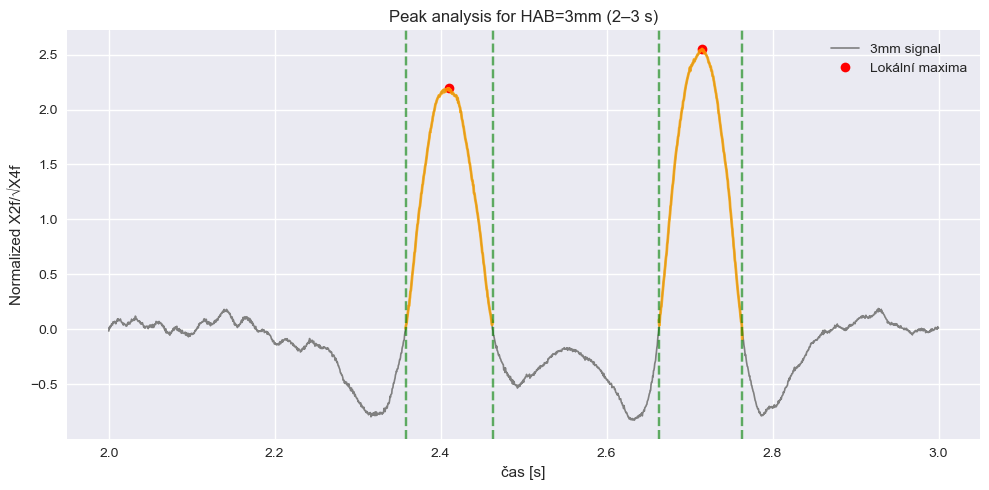

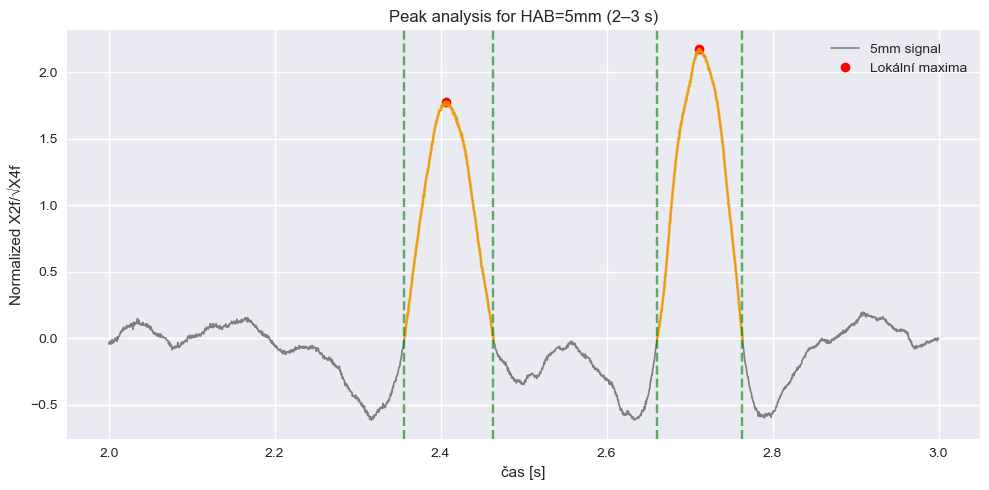

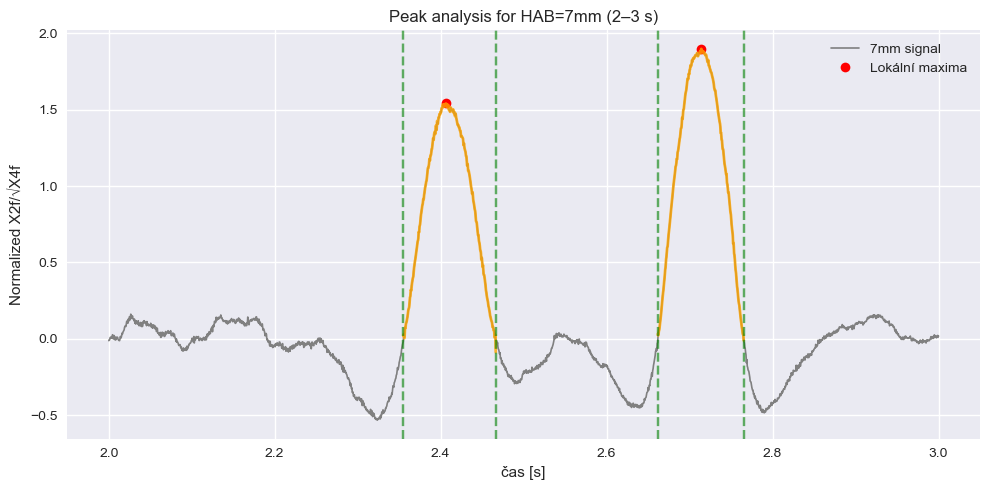

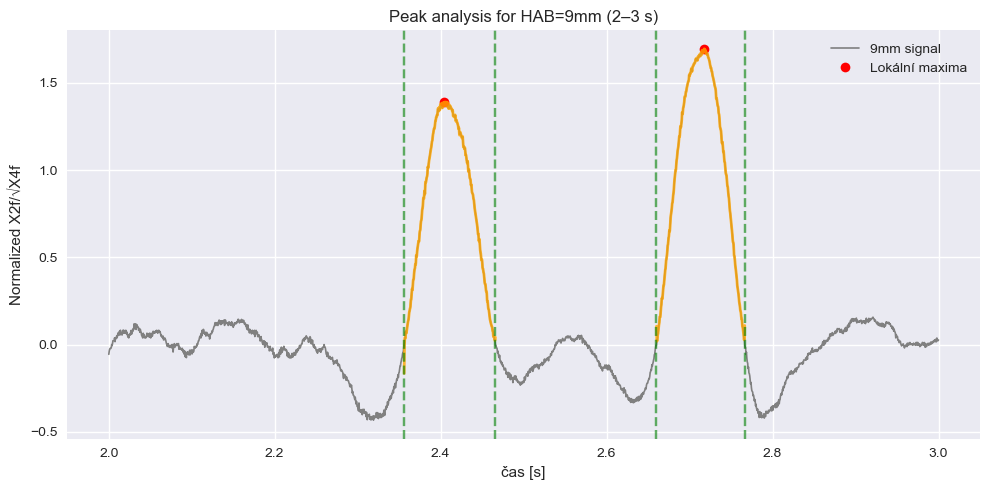

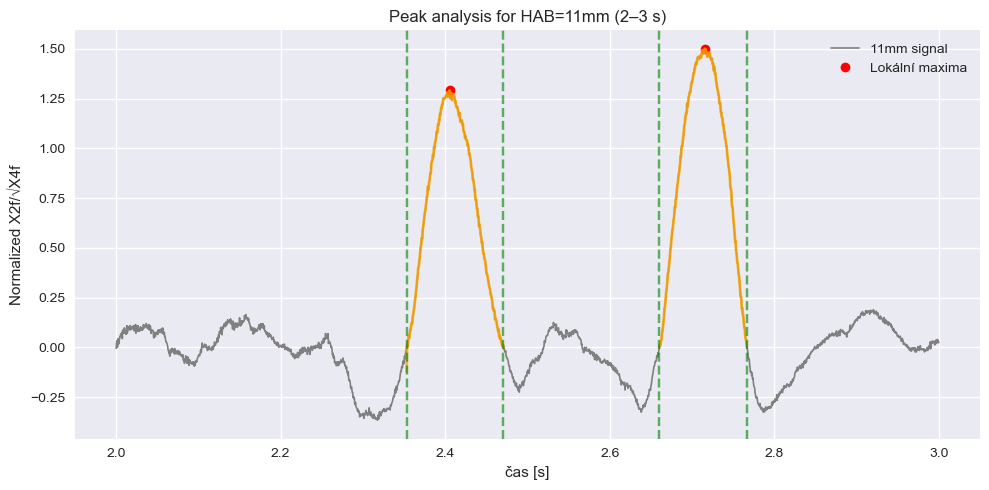


=== HAB 3mm ===
Peaks:
      x0        y0        xL        xR      area    height     width
0  2.410  2.192098  2.357687  2.462500  0.145022  2.193593  0.068895
1  2.715  2.552502  2.663000  2.763358  0.163264  2.552710  0.067576
Ratios:
     pair  ratio_area  ratio_height
0  (0, 1)    1.125789      1.163712

=== HAB 5mm ===
Peaks:
       x0        y0        xL        xR      area    height     width
0  2.4070  1.778422  2.356332  2.463600  0.114884  1.778543  0.066424
1  2.7115  2.175224  2.660857  2.763643  0.137145  2.174659  0.066121
Ratios:
     pair  ratio_area  ratio_height
0  (0, 1)    1.193763       1.22272

=== HAB 7mm ===
Peaks:
       x0        y0        xL        xR      area    height     width
0  2.4065  1.540070  2.355166  2.466333  0.100580  1.538982  0.066834
1  2.7140  1.895205  2.661749  2.765101  0.121079  1.896690  0.067313
Ratios:
     pair  ratio_area  ratio_height
0  (0, 1)    1.203814      1.232432

=== HAB 9mm ===
Peaks:
       x0        y0        xL        

In [53]:
# ============================================
# WaMoS: Doublet Analysis (2–3 s interval, experimental only)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simpson
from scipy.signal import find_peaks

# -----------------------------
# 1. Load normalized dataset
# -----------------------------
df_norm = pd.read_csv(
    "./exp/2025-11-30_Qin10_lmin_phi1_ch4air_Tld51stC_HAB(from3to11mm)_00000/2025-11-30_Qin10_lmin_phi1_ch4air_X2f4fnorm.csv"
)

# -----------------------------
# 2. Restrict to 2–3 s interval
# -----------------------------
t_min, t_max = 2.0, 3.0
mask = (df_norm["time_s"] >= t_min) & (df_norm["time_s"] <= t_max)
t_win = df_norm["time_s"][mask].values

# -----------------------------
# 3. Helper functions
# -----------------------------
def detect_maxima(x, y, distance=30, prominence=0.001):
    idx, _ = find_peaks(y, distance=distance, prominence=prominence)
    return idx

def zero_crossings_bounds(x, y, center_idx):
    """
    Find nearest zero crossings around a peak index by interpolation.
    """
    # Left side
    left = center_idx
    while left > 0 and y[left] * y[left-1] > 0:
        left -= 1
    if left > 0:
        xzc_l = x[left-1] - y[left-1]*(x[left]-x[left-1])/(y[left]-y[left-1])
    else:
        xzc_l = x[0]

    # Right side
    right = center_idx
    while right < len(y)-1 and y[right] * y[right+1] > 0:
        right += 1
    if right < len(y)-1:
        xzc_r = x[right] - y[right]*(x[right+1]-x[right])/(y[right+1]-y[right])
    else:
        xzc_r = x[-1]

    return xzc_l, xzc_r

def fwhm_width(xg, yg):
    y_max = np.max(yg)
    half = y_max/2.0
    above = yg >= half
    if not np.any(above):
        return np.nan
    idx = np.where(above)[0]
    return xg[idx[-1]] - xg[idx[0]]

def quantify_peaks_local_spline(x, y, maxima_idx):
    results = []
    for idx in maxima_idx:
        x0 = x[idx]
        y0 = y[idx]
        xL, xR = zero_crossings_bounds(x, y, idx)
        mask = (x >= xL) & (x <= xR)
        x_local = x[mask]
        y_local = y[mask]

        # Use interpolating spline (s=0) for stability
        spline_local = UnivariateSpline(x_local, y_local, s=0)
        xg = np.linspace(xL, xR, 500)
        yg = spline_local(xg)

        area = simpson(yg, x=xg)
        height = np.max(yg)
        width = fwhm_width(xg, yg)

        results.append({
            "x0": x0,
            "y0": y0,
            "xL": xL,
            "xR": xR,
            "area": area,
            "height": height,
            "width": width,
            "xg": xg,
            "yg": yg
        })
    ratios = []
    for i in range(len(results)-1):
        ratios.append({
            "pair": (i, i+1),
            "ratio_area": results[i+1]["area"]/results[i]["area"],
            "ratio_height": results[i+1]["height"]/results[i]["height"]
        })
    return results, ratios

# -----------------------------
# 4. Loop over HAB columns
# -----------------------------
hab_results = {}
for col in df_norm.columns[1:]:  # skip time_s
    y_win = df_norm[col][mask].values
    maxima_idx = detect_maxima(t_win, y_win, distance=30, prominence=0.1)
    threshold = 0.5 * np.max(y_win)
    maxima_idx_filtered = [i for i in maxima_idx if y_win[i] >= threshold]
    results, ratios = quantify_peaks_local_spline(t_win, y_win, maxima_idx_filtered)
    hab_results[col] = {"results": results, "ratios": ratios}

    # Plot for each HAB
    plt.figure(figsize=(10, 5))
    plt.plot(t_win, y_win, color='gray', lw=1.2, label=f'{col} signal')
    plt.plot(t_win[maxima_idx_filtered], y_win[maxima_idx_filtered], 'o', color='red', label='Lokální maxima')
    for r in results:
        plt.plot(r["xg"], r["yg"], color='orange', linewidth=2, alpha=0.8)
        plt.axvline(r["xL"], color='green', linestyle='--', alpha=0.6)
        plt.axvline(r["xR"], color='green', linestyle='--', alpha=0.6)
    plt.xlabel("čas [s]")
    plt.ylabel("Normalized X2f/√X4f")
    plt.title(f"Peak analysis for HAB={col} (2–3 s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# 5. Tabular summary
# -----------------------------
for hab, data in hab_results.items():
    print(f"\n=== HAB {hab} ===")
    df_peaks = pd.DataFrame([{k: v for k, v in r.items() if k not in ("xg","yg")} for r in data["results"]])
    df_ratios = pd.DataFrame(data["ratios"])
    print("Peaks:")
    print(df_peaks)
    print("Ratios:")
    print(df_ratios)


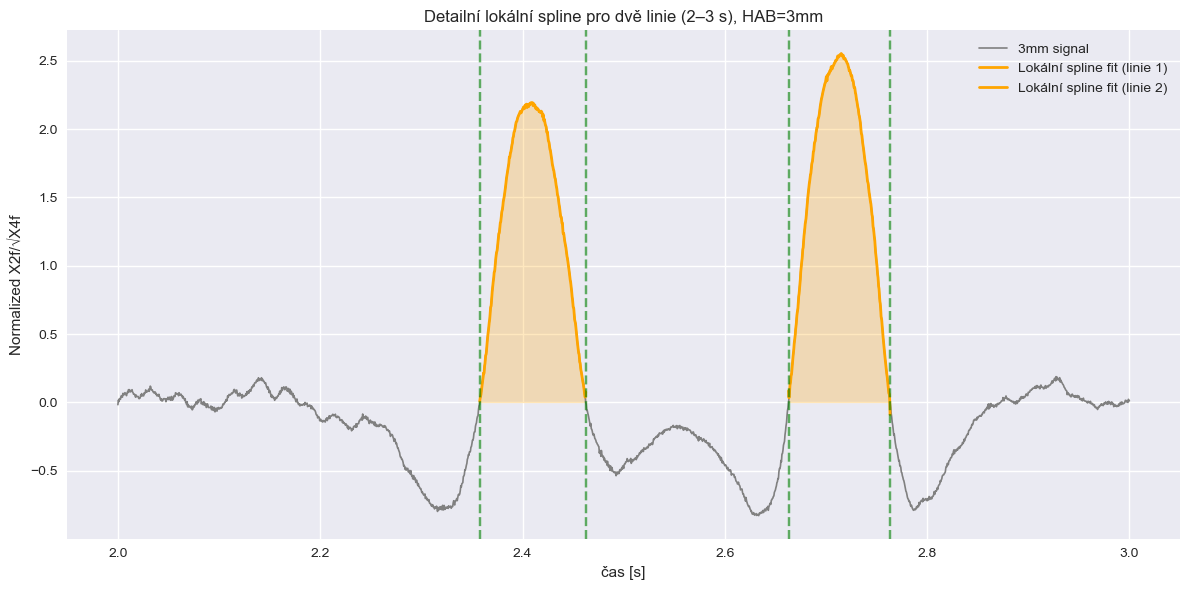


Detailní parametry dvou vybraných linií (HAB=3mm, 2–3 s):


,x0,y0,xL,xR,area,height,width
0,2.410,2.192098,2.357687,2.462500,0.145022,2.193593,0.068895
1,2.715,2.552502,2.663000,2.763358,0.163264,2.552710,0.067576


Poměry mezi dvěma vybranými liniemi (HAB=3mm, 2–3 s):


,HAB,linie_pair,ratio_area_exp,ratio_height_exp
0,3mm,1-2,1.125789,1.163712


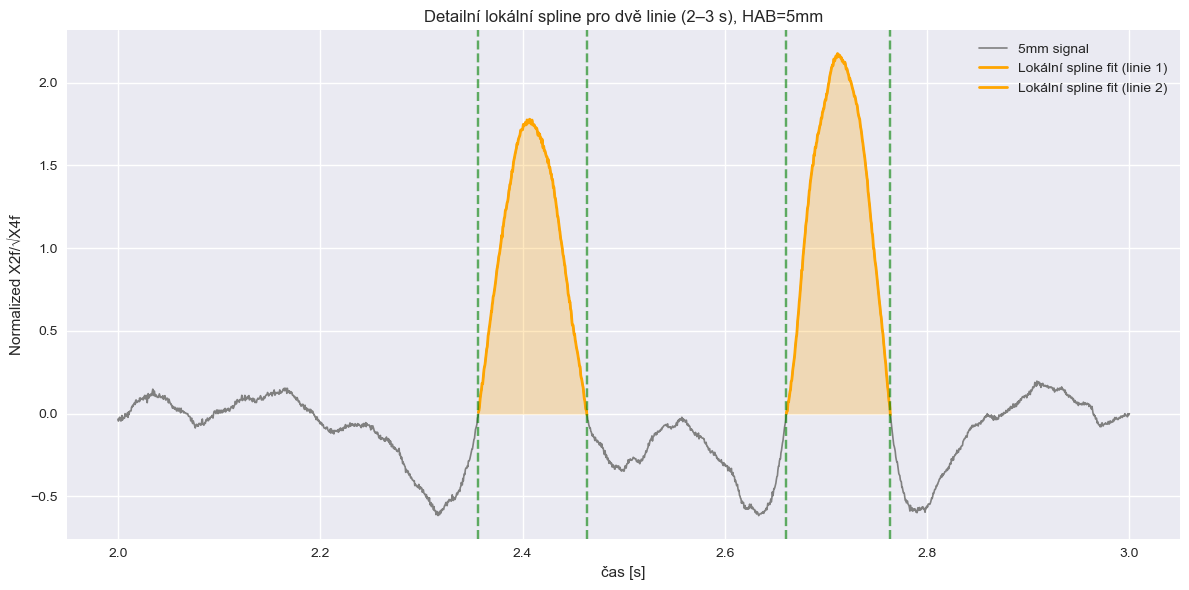


Detailní parametry dvou vybraných linií (HAB=5mm, 2–3 s):


,x0,y0,xL,xR,area,height,width
0,2.4070,1.778422,2.356332,2.463600,0.114884,1.778543,0.066424
1,2.7115,2.175224,2.660857,2.763643,0.137145,2.174659,0.066121


Poměry mezi dvěma vybranými liniemi (HAB=5mm, 2–3 s):


,HAB,linie_pair,ratio_area_exp,ratio_height_exp
0,5mm,1-2,1.193763,1.22272


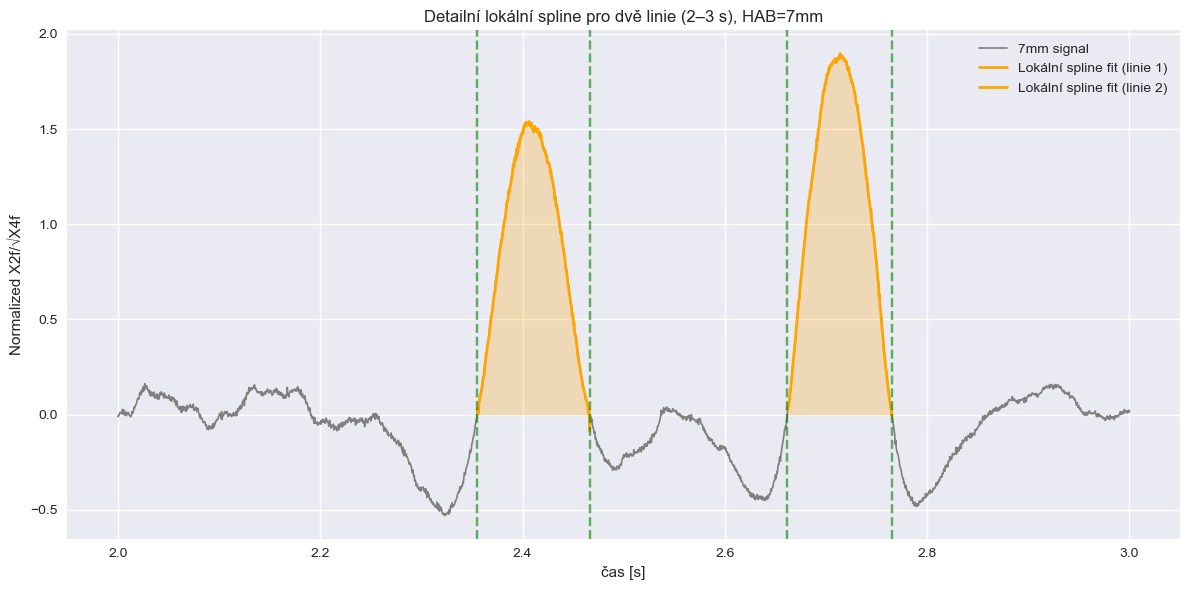


Detailní parametry dvou vybraných linií (HAB=7mm, 2–3 s):


,x0,y0,xL,xR,area,height,width
0,2.4065,1.540070,2.355166,2.466333,0.100580,1.538982,0.066834
1,2.7140,1.895205,2.661749,2.765101,0.121079,1.896690,0.067313


Poměry mezi dvěma vybranými liniemi (HAB=7mm, 2–3 s):


,HAB,linie_pair,ratio_area_exp,ratio_height_exp
0,7mm,1-2,1.203814,1.232432


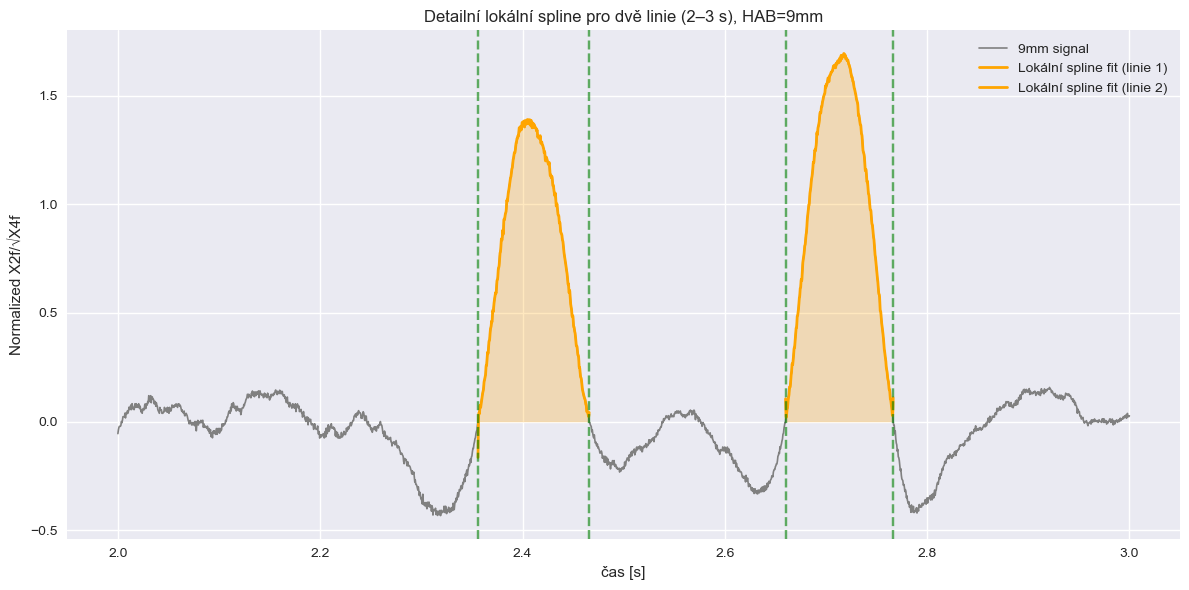


Detailní parametry dvou vybraných linií (HAB=9mm, 2–3 s):


,x0,y0,xL,xR,area,height,width
0,2.4045,1.389072,2.356000,2.465917,0.091135,1.389924,0.067404
1,2.7175,1.692998,2.660071,2.766444,0.109786,1.694470,0.066936


Poměry mezi dvěma vybranými liniemi (HAB=9mm, 2–3 s):


,HAB,linie_pair,ratio_area_exp,ratio_height_exp
0,9mm,1-2,1.204651,1.21911


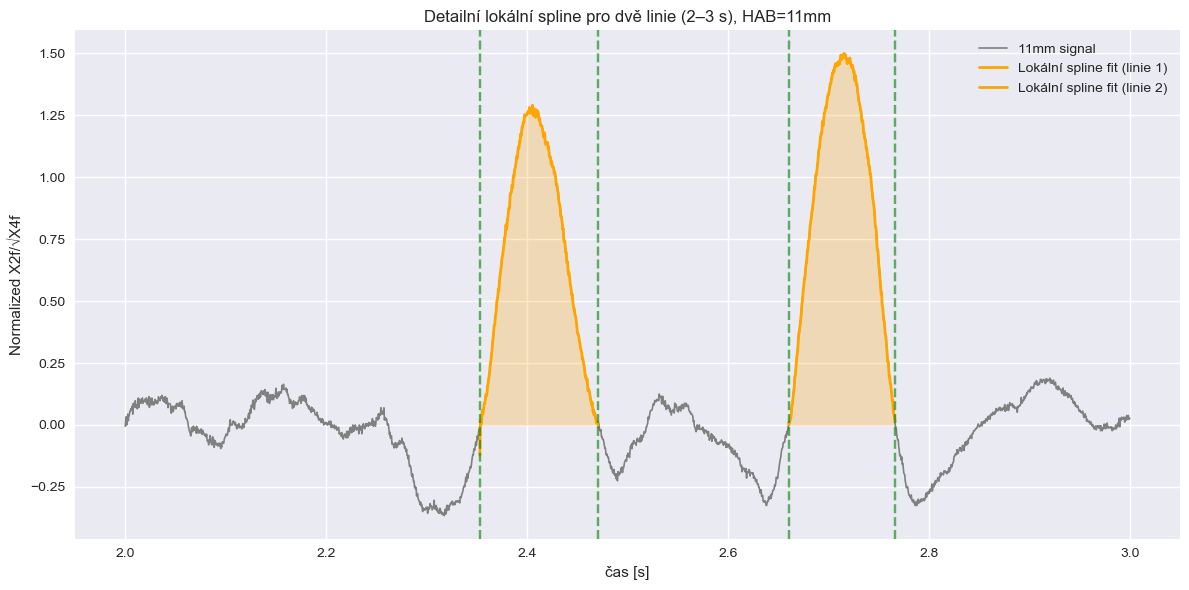


Detailní parametry dvou vybraných linií (HAB=11mm, 2–3 s):


,x0,y0,xL,xR,area,height,width
0,2.4055,1.290865,2.353000,2.470751,0.083476,1.290740,0.066073
1,2.7155,1.499133,2.660332,2.766500,0.097007,1.499391,0.067020


Poměry mezi dvěma vybranými liniemi (HAB=11mm, 2–3 s):


,HAB,linie_pair,ratio_area_exp,ratio_height_exp
0,11mm,1-2,1.162093,1.161652


In [54]:
# ============================================
# Detailní analýza pro dvě vybrané linie v intervalu 2–3 s (multi-HAB)
# ============================================

t_min_detail, t_max_detail = 2.0, 3.0

for hab, data in hab_results.items():
    results = data["results"]
    df_peaks = pd.DataFrame([{k: v for k, v in r.items() if k not in ("xg","yg")} for r in results])

    # Select candidate peaks in 2–3 s window
    candidates = df_peaks[(df_peaks["x0"] >= t_min_detail) & (df_peaks["x0"] <= t_max_detail)].index.tolist()
    if len(candidates) >= 2:
        idx1, idx2 = candidates[0], candidates[1]
    elif len(candidates) == 1:
        idx1, idx2 = candidates[0], candidates[0]  # fallback if only one peak
    else:
        continue  # skip if no peaks in window

    line1 = results[idx1]
    line2 = results[idx2]

    # Plot detail for this HAB
    plt.figure(figsize=(12, 6))
    mask_detail = (t_win >= t_min_detail) & (t_win <= t_max_detail)
    y_win = df_norm[hab][mask].values
    plt.plot(t_win[mask_detail], y_win[mask_detail], color='gray', lw=1.2, label=f'{hab} signal')

    for i, r in enumerate([line1, line2]):
        mask_local = (r["xg"] >= t_min_detail) & (r["xg"] <= t_max_detail)
        plt.plot(r["xg"][mask_local], r["yg"][mask_local], color='orange', linewidth=2,
                 label=f'Lokální spline fit (linie {i+1})')
        plt.axvline(r["xL"], color='green', linestyle='--', alpha=0.6)
        plt.axvline(r["xR"], color='green', linestyle='--', alpha=0.6)
        plt.fill_between(r["xg"][mask_local], r["yg"][mask_local], 0,
                         where=(r["xg"][mask_local]>=r["xL"]) & (r["xg"][mask_local]<=r["xR"]),
                         color='orange', alpha=0.25)

    plt.xlabel('čas [s]')
    plt.ylabel('Normalized X2f/√X4f')
    plt.title(f'Detailní lokální spline pro dvě linie (2–3 s), HAB={hab}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Tabulka parametrů obou linií
    df_detail = pd.DataFrame([
        {k: v for k, v in line1.items() if k not in ("xg","yg")},
        {k: v for k, v in line2.items() if k not in ("xg","yg")}
    ])

    print(f"\nDetailní parametry dvou vybraných linií (HAB={hab}, 2–3 s):")
    display(df_detail)

    # Ratios between the two lines
    ratio_area = line2["area"] / line1["area"] if line1["area"] != 0 else np.nan
    ratio_height = line2["height"] / line1["height"] if line1["height"] != 0 else np.nan

    df_detail_ratios = pd.DataFrame([{
        "HAB": hab,
        "linie_pair": f"{idx1+1}-{idx2+1}",
        "ratio_area_exp": ratio_area,
        "ratio_height_exp": ratio_height
    }])

    print(f"Poměry mezi dvěma vybranými liniemi (HAB={hab}, 2–3 s):")
    display(df_detail_ratios)
